# Autotalker Tutorial

- Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- Affiliation: Institute of Computational Biology, Helmholtz Munich, Talavera-López Lab
- Date of Creation: 01.10.2022

## 1. Setup

### 1.1 Import Libraries

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import argparse
import os
import random
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_cad,
                                     compute_cad,
                                     compute_avg_gcd,
                                     compute_max_lnmi,
                                     compute_per_cell_log_rclisi)
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions)

In [85]:
# Define default matplotlib figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)

### 1.2 Configure Paths and Create Directories

In [86]:
# Mlflow
os.makedirs("mlruns", exist_ok=True)

# Gene program data
gp_data_folder_path = "datasets/gp_data/"
srt_data_folder_path = "datasets/srt_data/"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Define Parameters

In [88]:
random_state = 42

## Datasets
dataset = "squidpy_seqfish_mouse_organogenesis"
#dataset = "squidpy_slideseqv2_mouse_hippocampus"
#dataset = "vizgen_merfish_mouse_brain"
#dataset = "vizgen_merfish_mouse_liver" 
#dataset = "vizgen_merfish_human_liver_cancer"
#dataset = "10x_xenium_human_breast_cancer"
#dataset = "starmap_plus_mouse_cns"
#dataset = "eel_fish_mouse_brain"
n_neighs = 10 # for spatial neighborhood graph; constrained by GPU memory

## Model Hyperparameters
# Neighborhood Gene Expression Aggregation (Node Label Method)
#node_label_method = "self"
#node_label_method = "one-hop-sum"
#node_label_method = "one-hop-norm"
node_label_method = "one-hop-attention"
n_latent_fc_gps = 512
edge_batch_size = 32 # training does not work when too small (noisy gradients); training does not work when too high (GPU memory constraints); this is a very important hyperparameter

In [89]:
random.seed(42)

## 2. Data

### 2.1 Load & Preprocess Data

#### 2.1.1 Squidpy seqFISH Mouse Organogenesis Dataset

- **Publication:** Lohoff, T. et al. Highly multiplexed spatially resolved gene expression profiling of mouse organogenesis. bioRxiv 2020.11.20.391896 (2020). [doi:10.1101/2020.11.20.391896](https://doi.org/10.1101/2020.11.20.391896)
- **Data Access:** Preprocessed version from squidpy API (original source https://marionilab.cruk.cam.ac.uk/SpatialMouseAtlas/)
- **Summary:**
    - Sagittal tissue section of 8-12 somite-stage mouse embryo
    - 19,416 observations on cell-level with cell-type annotations
    - 351 probed genes

In [90]:
if dataset == "squidpy_seqfish_mouse_organogenesis":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.seqfish()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "celltype_mapped_refined"
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

Loading and preprocessing dataset 'squidpy_seqfish_mouse_organogenesis'.


#### 2.1.2 Squidpy Slide-seqV2 Mouse Hippocampus Dataset

- **Publication**: Stickels, R. R. et al. Highly sensitive spatial transcriptomics at near-cellular resolution with Slide-seqV2. Nat. Biotechnol. 39, 313–319 (2021). [doi:10.1038/s41587-020-0739-1](https://doi.org/10.1038/s41587-020-0739-1)
- **Data Access:** Preprocessed version from squidpy API (original source https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2)
- **Summary:**
    - Mouse hippocampus puck
    - 41,786 observations on cell-level with cell-type annotations
    - 4,000 probed genes

In [ ]:
if dataset == "squidpy_slideseqv2_mouse_hippocampus":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.slideseqv2()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "cluster"
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.3 Vizgen MERFISH Mouse Brain Receptor Dataset

- **Publication:** Vizgen Data Release V1.0. May 2021
- **Data Access:** https://info.vizgen.com/mouse-brain-map?submissionGuid=a66ccb7f-87cf-4c55-83b9-5a2b6c0c12b9
    - Slice 1 Replicate 1
        - cell_by_gene_S1R1.csv
        - cell_metadata_S1R1.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen.html
- **Summary:**
    - Coronal section of mouse brain receptor map
    - 78,329 observations on cell-level without annotations
    - 649 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")

    # Read adata from files
    merfish_dir = "datasets/srt_data/merfish/"
    adata = sq.read.vizgen(path=merfish_dir,
                           counts_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv",
                           meta_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv")

    # Preprocess as per squidpy vignette
    adata.var_names.unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.histplot(adata.obs["total_counts"],
                 kde=False,
                 ax=axs[0])
    sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
                 kde=False,
                 bins=40,
                 ax=axs[1])
    sns.histplot(adata.obs["n_genes_by_counts"],
                 kde=False,
                 bins=60,
                 ax=axs[2])
    sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
                 kde=False,
                 bins=60,
                 ax=axs[3])
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden",])
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.4 Vizgen MERFISH Mouse Liver Dataset

- **Publication**: Vizgen MERFISH Mouse Liver Map January 2022
- **Data Access:** https://info.vizgen.com/mouse-liver-access
    - Animal 1 replicate 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen_mouse_liver.html
- **Summary:**
    - Liver tissue section of mouse liver map
    - 367,335 observations on cell-level without annotations
    - 385 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_liver":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from files
    merfish_dir = "datasets/srt_data/merfish/"
    adata = sq.read.vizgen(merfish_dir,
                           counts_file="Liver1Slice1_cell_by_gene.csv",
                           meta_file="Liver1Slice1_cell_metadata.csv")
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.5)
    
    sc.set_figure_params(figsize=(10,10))
    sc.pl.umap(adata, color=["leiden"], size=5)
    
    gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
    df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
    df_ref_panel = df_ref_panel_ini.iloc[1:,:1]
    df_ref_panel.index.name = None
    df_ref_panel.columns = ["Function"]
    
    # Assign marker gene metadata using reference dataset
    marker_genes = df_ref_panel[df_ref_panel["Function"].str.contains("marker")].index.tolist()
    
    meta_gene = deepcopy(adata.var)
    common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    meta_gene["Markers"] = meta_gene["Markers"].apply(lambda x: "N.A." if "marker" not in str(x) else x)
    meta_gene["Markers"].value_counts()
    
    ser_counts = adata.obs["leiden"].value_counts()
    ser_counts.name = "cell counts"
    meta_leiden = pd.DataFrame(ser_counts)
    
    cat_name = "leiden"
    sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
    for clust in adata.obs[cat_name].cat.categories:
        sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
    sig_leiden = sig_leiden.transpose()
    leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
    sig_leiden.columns = leiden_clusters
    meta_leiden.index = sig_leiden.columns.tolist()
    meta_leiden["leiden"] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())
    
    meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
    meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
    meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    
    meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
    num_top_genes = 30
    for inst_cluster in sig_leiden.columns.tolist():
        top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]
    
        inst_ser = meta_gene.loc[top_genes, "Markers"]
        inst_ser = inst_ser[inst_ser != "N.A."]
        ser_counts = inst_ser.value_counts()
      
        max_count = ser_counts.max()
      
        max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
        max_cat = max_cat.replace(" marker", "").replace(" ", "-")
      
        print(inst_cluster, max_cat)
        meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat
    
    # Rename clusters
    meta_leiden["name"] = meta_leiden.apply(lambda x: x["Cell_Type"] + "_" + x["leiden"] , axis=1)
    leiden_names = meta_leiden["name"].values.tolist()
    meta_leiden.index = leiden_names
    
    # Transfer cell type labels to single cells
    leiden_to_cell_type = deepcopy(meta_leiden)
    leiden_to_cell_type.set_index("leiden", inplace=True)
    leiden_to_cell_type.index.name = None
    
    adata.obs["Cell_Type"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"])
    adata.obs["Cluster"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"])
    cell_type_key = "Cell_Type"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.5 Vizgen MERFISH Human Liver Cancer Dataset

- **Publication:** Vizgen MERFISH FFPE Human Immuno-oncology Data Set,  May 2022
- **Data Access:** https://info.vizgen.com/ffpe-showcase?submissionGuid=bbe0d6ca-92ad-4257-bdcd-cbc6dee8219b
    - Liver cancer 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Summary:**
    - FFPE tissue section of human liver cancer
    - 480,592 observations on cell-level without annotations
    - 500 probed genes

In [ ]:
if dataset == "vizgen_merfish_human_liver_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and remove blank genes
    vizgen_dir = "datasets/srt_data/merfish/"
    adata = ad.read_text(vizgen_dir + "HumanLiverCancerPatient1_cell_by_gene.csv" ,delimiter=",", first_column_names=True)
    blank_genes = np.array(["Blank" in v for v in adata.var_names])
    adata.obsm["blank_genes"] = pd.DataFrame(adata[:, blank_genes].X.copy(), columns=adata.var_names[blank_genes], index=adata.obs_names)
    adata = adata[:, ~blank_genes].copy()
    adata.X = sp.csr_matrix(adata.X)
    
    # Read metadata and align index for join
    metadata = pd.read_csv(vizgen_dir + "HumanLiverCancerPatient1_cell_metadata.csv", header=0, index_col=0)
    metadata.sort_index(inplace=True)
    metadata.index = metadata.index.astype("str")
    
    # Join counts with obs and store spatial coordinates
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["center_x", "center_y"]].values
    adata.obs.drop(columns=["center_x", "center_y"], inplace=True)
    
    # Preprocess
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden"])
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.6 10x Genomics Xenium Human Breast Cancer Tumor Microenvironment Dataset

- **Publication:** Janesick, A. et al. High resolution mapping of the breast cancer tumor microenvironment using integrated single cell, spatial and in situ analysis of FFPE tissue. bioRxiv 2022.10.06.510405 (2022). [doi:10.1101/2022.10.06.510405](https://doi.org/10.1101/2022.10.06.510405)
- **Data Access:** https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast
    - Feature-cell matrix (HDF5)
    - Cell summary file (CSV) -> unpack with ```gzip -d Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz```
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_xenium.html
- **Summary**:
    - FFPE tissue section of human breast cancer
    - 164,079 observations on cell-level without annotations
    - 313 probed genes

In [ ]:
if dataset == "10x_xenium_human_breast_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file and add metadata
    xenium_dir = "datasets/srt_data/xenium/"
    adata = sc.read_10x_h5(filename=xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
    metadata = pd.read_csv(xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv")
    metadata.set_index(adata.obs_names, inplace=True)
    adata.obs = metadata.copy()
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.layers["counts"] = adata.X.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.7 STARmap PLUS Mouse Central Nervous System Dataset

- **Publication:** Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022). [doi:10.1101/2022.06.20.496914](https://doi.org/10.1101/2022.06.20.496914)
- **Data Access:** https://singlecell.broadinstitute.org/single_cell/study/SCP1830
    - Sagittal 1 (Slice 3)
        - sagittal1_spatial.csv
        - sagittal1raw_expression_pd.csv
- **Summary:**
    - Sagittal section of mouse brain
    - 91,246 observations on cell-level with cell-type annotations
    - 1022 genes

In [ ]:
if dataset == "starmap_plus_mouse_cns":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and metadata and change format
    starmap_plus_dir = "datasets/srt_data/starmap_plus/"
    metadata = pd.read_csv(starmap_plus_dir + "sagittal1_spatial.csv", skiprows=[1])
    counts = pd.read_csv(starmap_plus_dir + "sagittal1raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    metadata.set_index("NAME", inplace=True)
    counts = counts.T
    
    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Maintype_Symbol"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

#### 2.1.8 EEL FISH Mouse Brain Dataset

- **Publication:** Borm, L. E. et al. Scalable in situ single-cell profiling by electrophoretic capture of mRNA using EEL FISH. Nat. Biotechnol. (2022) [doi:10.1038/s41587-022-01455-3](https://doi.org/10.1038/s41587-022-01455-3)
- **Data Accress:** https://figshare.com/articles/dataset/EEL_Mouse_440_genes_single_cell_data/20310771
    - LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad
- **Summary:**
    - Sagittal mouse brain section
    - 127,591 observations on cell-level with cluster annotations 
    - 440 genes

In [ ]:
if dataset == "eel_fish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file
    eel_fish_dir = "datasets/srt_data/eel_fish/"
    adata = sc.read_h5ad(eel_fish_dir + "LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad")
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "X_um", "Y_um"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Clusters"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
else:
    print("No action taken.")

### 2.2 Explore Data

Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Average number of edges per node: 10.0
Number of total edges: 97784
--------------------


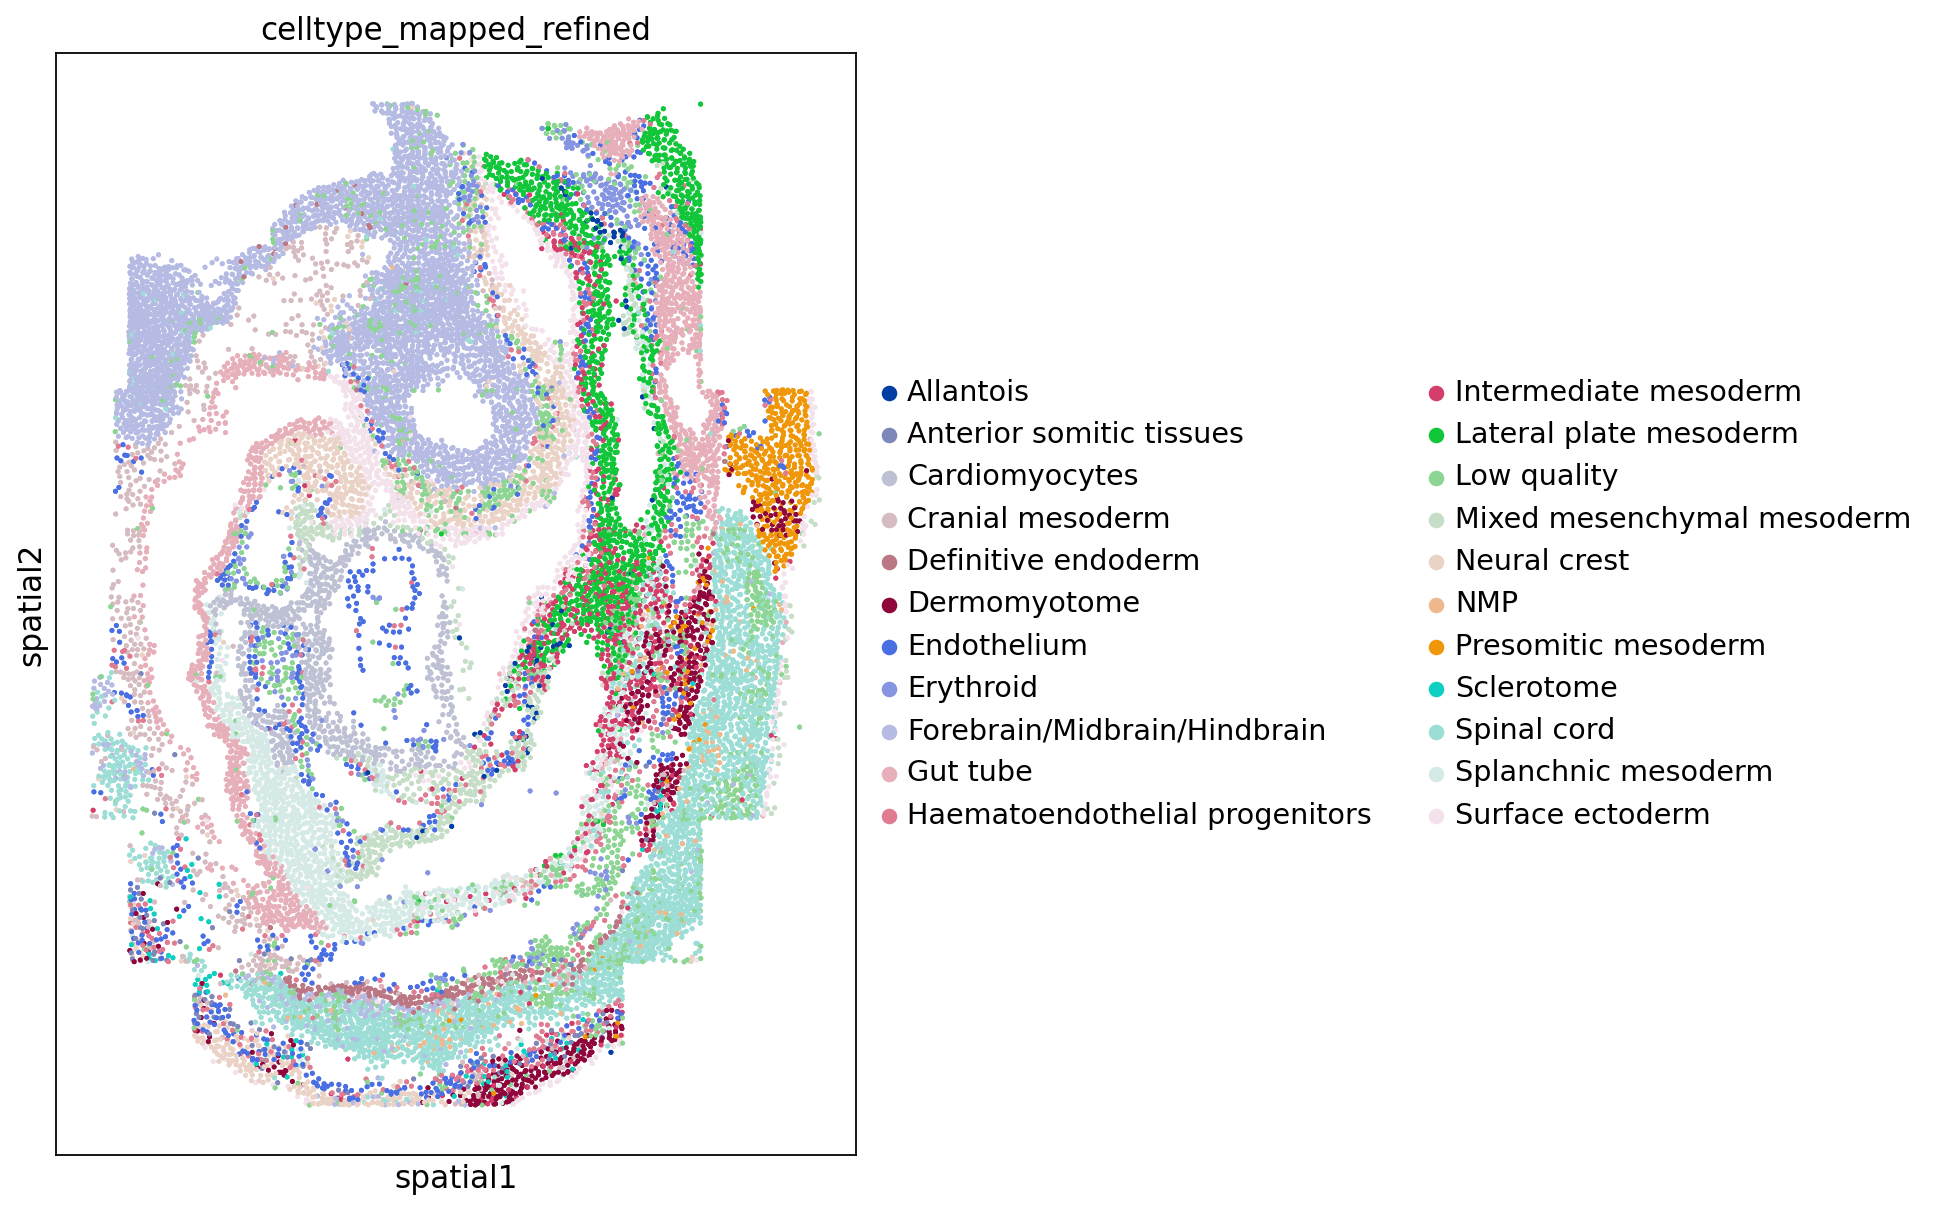

In [91]:
print(f"Using dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}", sep="")
print("--------------------")
# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [92]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

gp_targets_mask shape: (512, 351).
gp_sources_mask shape: (512, 351).


### 3.2 Initialize, Train & Save Model

In [93]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-attention
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_addon_input: 0, n_output: 702


In [94]:
# experiment = mlflow.set_experiment("autotalker_fc_gps")
# mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None,
            verbose=True) #experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 83117
Number of validation edges: 9778
Number of test edges: 4889

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.9525; val_auprc_score: 0.9330; val_best_acc_score: 0.8987; val_best_f1_score: 0.9059; train_edge_recon_loss: 0.8420; train_kl_loss: 0.5952; train_gene_expr_recon_loss: 429.9114; train_loss: 431.3486; val_edge_recon_loss: 0.4955; val_kl_loss: 0.6930; val_gene_expr_recon_loss: 427.2050; val_loss: 428.3935

Model training finished after 3 min 19 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.9527
Test AUPRC score: 0.9375
Test best accuracy score: 0.8961
Test best F1 score: 0.9013


In [95]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_fc_gps",
                        adata=None,
                        adata_file_name="adata.h5ad")

### 3.3. Visualize Latent Gene Programs with scanpy

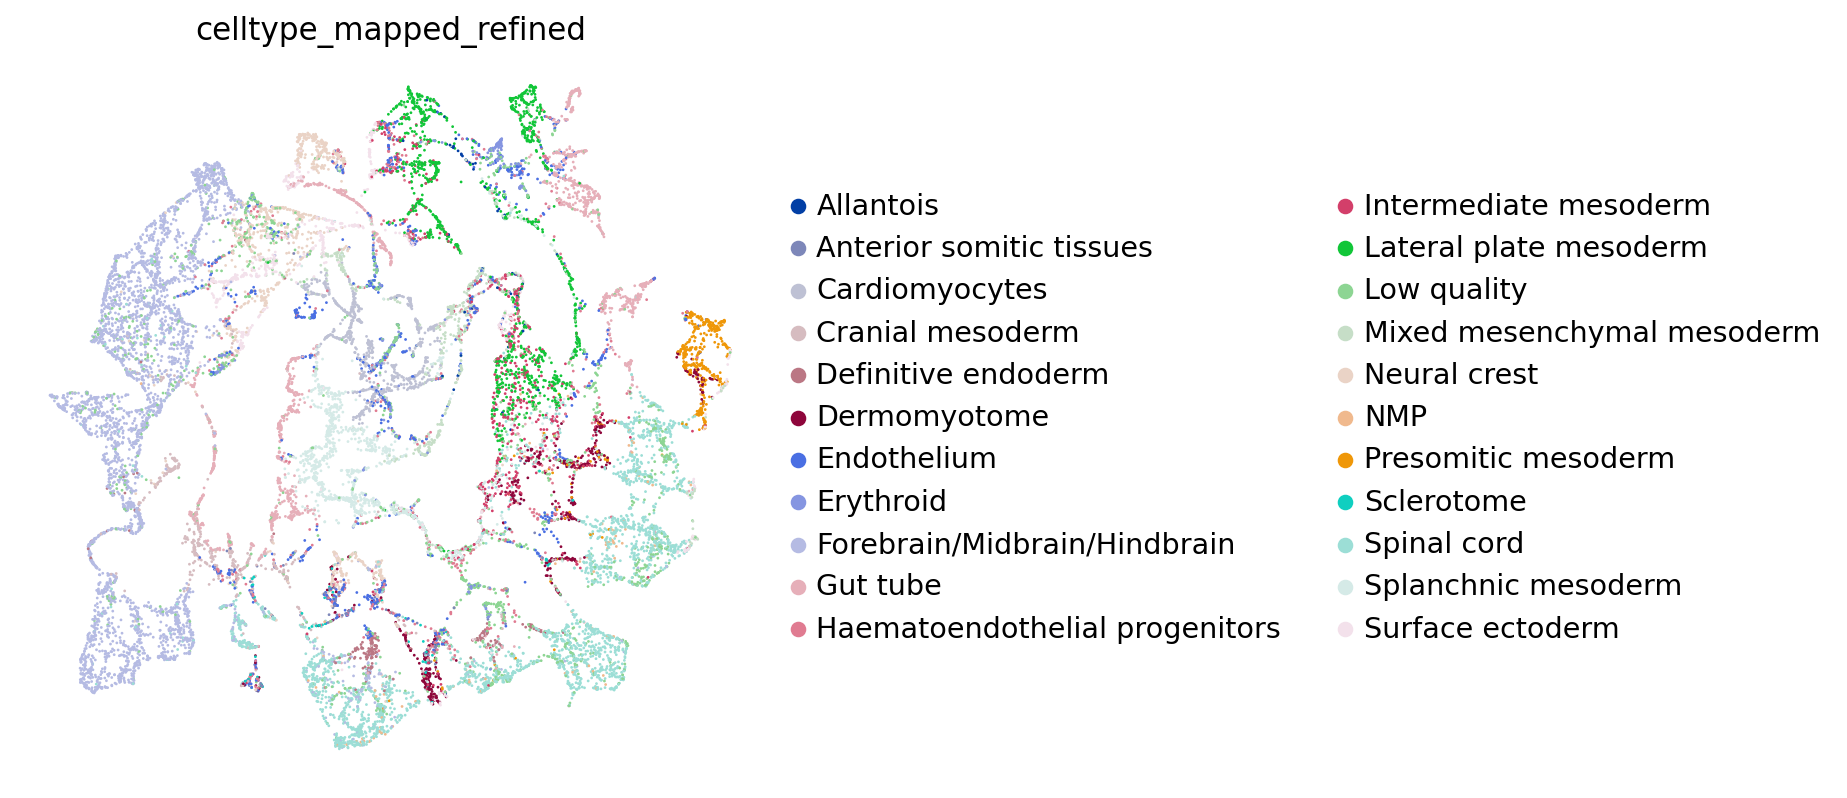

In [82]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_fc_gps_{current_time}.png")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 NicheNet Ligand Target Gene CCI Gene Programs

#### 4.1.1 Create NicheNet CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gps_targets",
    gp_sources_varm_key="autotalker_nichenet_gps_sources",
    gp_names_uns_key="autotalker_nichenet_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gps_sources'].sum()}.")

In [ ]:
nichenet_gps_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_targets"].T, dtype=torch.float32)
nichenet_gps_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_sources"].T, dtype=torch.float32)
nichenet_gps_mask = torch.cat((nichenet_gps_targets_mask, nichenet_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gps_mask.shape}.")
nichenet_gps_n_hidden_encoder = int(nichenet_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gps_n_hidden_encoder}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gps_targets",
                   gp_sources_mask_key="autotalker_nichenet_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_nichenet_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.1.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_nichenet_gps_{current_time}.png")

### 4.2 OmniPath Ligand Receptor CCI Gene Programs

#### 4.2.1 Create OmniPath CCI Gene Program Mask

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gps_targets",
    gp_sources_varm_key="autotalker_omnipath_gps_sources",
    gp_names_uns_key="autotalker_omnipath_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gps_sources'].sum()}.")

In [ ]:
omnipath_gps_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_targets"].T, dtype=torch.float32)
omnipath_gps_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_sources"].T, dtype=torch.float32)
omnipath_gps_mask = torch.cat((omnipath_gps_targets_mask, omnipath_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gps_mask.shape}.")
omnipath_gps_n_hidden_encoder = int(omnipath_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gps_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gps_targets",
                   gp_sources_mask_key="autotalker_omnipath_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_omnipath_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_omnipath_gps_{current_time}.png")

### 4.3 Mebocost Metabolite Enzyme Sensor CCI Gene Programs

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(species="mouse")

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=mebocost_gp_dict,
    genes_uppercase=False,
    gp_targets_varm_key="autotalker_mebocost_gps_targets",
    gp_sources_varm_key="autotalker_mebocost_gps_sources",
    gp_names_uns_key="autotalker_mebocost_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_mebocost_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_mebocost_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_mebocost_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_mebocost_gps_sources'].sum()}.")

In [ ]:
mebocost_gps_targets_mask = torch.tensor(adata.varm["autotalker_mebocost_gps_targets"].T, dtype=torch.float32)
mebocost_gps_sources_mask = torch.tensor(adata.varm["autotalker_mebocost_gps_sources"].T, dtype=torch.float32)
mebocost_gps_mask = torch.cat((mebocost_gps_targets_mask, mebocost_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {mebocost_gps_mask.shape}.")
mebocost_gps_n_hidden_encoder = int(mebocost_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {mebocost_gps_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_mebocost_gps_targets",
                   gp_sources_mask_key="autotalker_mebocost_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=mebocost_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_mebocost_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_mebocost_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_mebocost_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_mebocost_gps_{current_time}.png")

### 4.4 Combined Prior Knowledge CCI Gene Programs

#### 4.4.1 Create Combined Prior Knowledge CCI Gene Program Mask

In [ ]:
# Extract NicheNet ligand target gene gene programs into a dictionary
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
list(nichenet_gp_dict.keys())[:5]

In [ ]:
# Extract OmniPath ligand receptor gene programs into a dictionary
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
list(omnipath_gp_dict.keys())[:5]

In [ ]:
# Extract MEBOCOST enzyme sensor gene programs into a dictionary
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    species="mouse",
    genes_uppercase=True)

In [ ]:
list(mebocost_gp_dict.keys())[:5]

In [ ]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [ ]:
#  Add the gene program dictionary to the AnnData object
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gp_targets",
    gp_sources_varm_key="autotalker_combined_gp_sources",
    gp_names_uns_key="autotalker_combined_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
# Print gene program info
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_combined_gp_names'], 5)}.")
print(f"Number of total gene program target genes: {adata.varm['autotalker_combined_gp_targets'].sum()}.")
print(f"Number of total gene program source genes: {adata.varm['autotalker_combined_gp_sources'].sum()}.")

In [ ]:
# Create gene program mask
combined_gp_targets_mask = torch.tensor(adata.varm["autotalker_combined_gp_targets"].T, dtype=torch.float32)
combined_gp_sources_mask = torch.tensor(adata.varm["autotalker_combined_gp_sources"].T, dtype=torch.float32)
combined_gp_mask = torch.cat((combined_gp_targets_mask, combined_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gp_mask.shape}.")
combined_gp_n_hidden_encoder = int(combined_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gp_n_hidden_encoder}.")

#### 4.4.2 Initialize, Train & Save Model

In [ ]:
# Pass masks either trough ´gp_targets_mask_key´ and ´gp_sources_mask_key´ of adata or directly
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gp_targets",
                   gp_sources_mask_key="autotalker_combined_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=32,
            grad_clip_value=5,
            mlflow_experiment_id=experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_combined_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

#### 4.4.3 Visualize Latent Gene Programs

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["autotalker_combined_gp_latent"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="autotalker_combined_gp_latent")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_autotalker_combined_gp_latent_{current_time}.png")

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]
selected_gene_programs = ["CSF1_ligand_targetgenes_GP", "IL34_ligand_targetgenes_GP"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1_ligand_targetgenes_GP"] = latent_selected_gps[:, 0]
adata.obs["IL34_ligand_targetgenes_GP"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="CSF1_ligand_targetgenes_GP", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

### 4.5 Learn New CCI Gene Programs

In [ ]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_nichenet_gps",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        n_addon_gps=10,
                        freeze_non_addon_weights=True)

In [ ]:
model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None,
            verbose=True) #experiment.experiment_id)

In [ ]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

### 5. Benchmarking

#### Graph Connectivity Distance (GCD)

Measures the edge preservation in the latent space vs the physical space.

In [ ]:
avg_gcd = compute_avg_gcd(adata=adata,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_fc_gps",
                          seed=random_state)
print("Average graph connectivity distance:", avg_gcd)

#### Leiden Normalized Mutual Info (LNMI)

Measures the preservation of spatial organization by comparing cluster overlaps between the latent space and physical space.

In [ ]:
max_lnmi = compute_max_lnmi(adata=adata,
                            spatial_key="spatial",
                            latent_key="latent_autotalker_fc_gps",
                            seed=random_state,
                            visualize_leiden_clustering=True)
print(f"Maximum Leiden Normalized Mutual Info: {max_lnmi}.")

#### Cell-type Affinity Distance (CAD)

Measures preservation of cell-cell contact maps, that means cell-type enrichments in a cell’s neighborhood across all cells, in latent space vs physical space.

In [ ]:
avg_cad = compute_avg_cad(adata=adata,
                          cell_type_key=cell_type_key,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_fc_gps",
                          seed=random_state)
print("Average cell-type affinity distance:", avg_cad)

In [ ]:
cad = compute_cad(adata=adata,
                  cell_type_key=cell_type_key,
                  spatial_key="spatial",
                  latent_key="latent_autotalker_fc_gps",
                  n_neighbors=15,
                  seed=random_state,
                  visualize_ccc_maps=True)
print("Cell-type affinity distance:", cad)

#### Relative Cell-type Local Inverse Simpson's Index (RCLISI)

Measures preservation of spatial cell-type heterogeneity in latent space vs physical space.

In [ ]:
per_cell_log_rclisi_df = compute_per_cell_log_rclisi(adata=adata,
                                                     cell_type_key=cell_type_key,
                                                     spatial_key="spatial",
                                                     latent_key="latent_autotalker_fc_gps",
                                                     n_neighbors=15,
                                                     seed=random_state)

In [ ]:
sns.displot(per_cell_log_rclisi_df, x="log_rclisi", kind="kde", bw_adjust=2, height=3, aspect=10)

#### Gene Expression Reconstruction (GER)

### 6. Analysis

#### 6.1 Compute Latent Graph Connectivities 

In [ ]:
latent_key = "autotalker_combined_gp_latent"
gp_key = "autotalker_combined_gp_names"

In [ ]:
model.compute_latent_graph_connectivities(adata=None,
                                          latent_key=latent_key,
                                          n_neighbors=15,
                                          mode="knn",
                                          seed=42)

In [ ]:
# Compute latent Leiden clustering
resolution = 0.4

sc.tl.leiden(adata=adata,
             resolution=resolution,
             random_state=random_state,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=adata.obsp["latent_connectivities"])

# Visualize latent Leiden clusters in latent space
sc.pp.neighbors(adata=adata, use_rep=latent_key)
sc.tl.umap(adata=adata, min_dist=0.3)
sc.pl.umap(adata=adata,
           color=[f"latent_leiden_{str(resolution)}"],
           frameon=False,
           title=f"latent_leiden_{str(resolution)} clusters in latent space")

# Visualize latent Leiden clusters in physical space
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.spatial(adata=adata,
                  color=[f"latent_leiden_{str(resolution)}"],
                  ncols=5,
                  spot_size=0.03,
                  title=f"latent_leiden_{str(resolution)} clusters in physical space")

#### 6.1 Gene Program Enrichment Scores

##### 6.1.1 Cell-type Gene Program Enrichment Scores

In [ ]:
model.calculate_gp_enrichment_scores(cat_key=cell_type_key,
                                     gp_key=gp_key,
                                     adata=adata,
                                     comparison_cats="rest",
                                     selected_gps=["WNT2B_ligand_receptor_GP", "PECAM1_ligand_receptor_GP"],
                                     n_sample=1000,
                                     key_added="autotalker_combined_gp_cell_type_gp_enrichment_scores")

In [ ]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"].head()

##### 6.1.2 Spatial Gene Program Enrichment Scores

In [ ]:
model.calculate_gp_enrichment_scores(cat_key=f"latent_leiden_{str(resolution)}",
                                     gp_key=gp_key,
                                     adata=adata,
                                     comparison_cats="rest",
                                     selected_gps=["WNT2B_ligand_receptor_GP", "PECAM1_ligand_receptor_GP"],
                                     n_sample=1000,
                                     key_added="autotalker_combined_gp_cell_type_gp_enrichment_scores")

In [ ]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"].head()

#### 6.3 Gene Program Gene Importances

In [ ]:
model.compute_gp_gene_importances(gp_name="WNT2B_ligand_receptor_GP",
                                  gp_key=gp_key)

In [ ]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"]